# With ViT


In [1]:
import numpy as np
import pandas as pd
import os
import glob
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D, Input, Reshape, LayerNormalization, MultiHeadAttention, Dropout, Add, GlobalAveragePooling1D
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import precision_recall_curve, auc

In [2]:
BASE_DIR = "./dataset/"
CSV_PATH = os.path.join(BASE_DIR, "Data_Entry_2017.csv")

# Gather all image files across the 12 folders
IMAGE_DIR = os.path.join(BASE_DIR, "images")
IMAGE_FILES = {os.path.basename(f): f for f in glob.glob(os.path.join(IMAGE_DIR, "*.png"))}

print(f"Total images found: {len(IMAGE_FILES)}")

Total images found: 112120


In [4]:
# Load CSV and extract relevant columns
df = pd.read_csv(CSV_PATH)
df = df[['Image Index', 'Finding Labels']]
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|'))

# Define the disease labels you're interested in
labels = ['Pneumonia', 'Cardiomegaly', 'Edema', 'Emphysema', 'Effusion', 'Infiltration', 'Atelectasis']

# One-hot encode the disease labels
for label in labels:
    df[label] = df['Finding Labels'].apply(lambda x: 1 if label in x else 0)

# Compute the total number of labels per row (helps identify "No Finding")
df['has_label'] = df[labels].sum(axis=1)

# Split into disease and "No Finding" groups
disease_df = df[df['has_label'] > 0]
no_finding_df = df[df['has_label'] == 0]

# Downsample "No Finding" rows to balance the dataset
downsample_ratio = 0.3  # You can tune this ratio
desired_no_finding = int(len(disease_df) * downsample_ratio)
downsampled_no_finding_df = no_finding_df.sample(n=desired_no_finding, random_state=42)

# Combine and shuffle the final dataset
balanced_df = pd.concat([disease_df, downsampled_no_finding_df]).sample(frac=1, random_state=42).reset_index(drop=True)

# Train-validation split
train_df, val_df = train_test_split(balanced_df, test_size=0.2, random_state=42)

In [3]:
# (EXCLUDING 'NO FINDING')
# Load CSV and extract relevant columns 
df = pd.read_csv(CSV_PATH) 
df = df[['Image Index', 'Finding Labels']]
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|'))

labels = ['Pneumonia', 'Cardiomegaly', 'Edema', 'Emphysema', 'Effusion', 'Infiltration', 'Atelectasis']

# One-hot encode the labels
for label in labels:
    df[label] = df['Finding Labels'].apply(lambda x: 1 if label in x else 0)

# Optional: keep 'No Finding' rows but assign all-zero labels
df['has_label'] = df[labels].sum(axis=1)
df = df[df['has_label'] > 0]  # If you want to exclude "No Finding" images, comment this out to keep them

# Train-validation split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [4]:
datagen = ImageDataGenerator(rescale=1./255)

# With augmentation
train_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True
)

# Add the 'path' column to train_df and val_df
train_df['path'] = train_df['Image Index'].map(IMAGE_FILES)
val_df['path'] = val_df['Image Index'].map(IMAGE_FILES)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,  # Set to None since paths are absolute
    x_col='path',
    y_col=labels,
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=None,  # Set to None since paths are absolute
    x_col='path',
    y_col=labels,
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    shuffle=False
)

Found 31659 validated image filenames.
Found 7915 validated image filenames.


ResNet-50 + ViT 

In [5]:
# Define Transformer Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    
    # Multi-head attention
    attention_output = MultiHeadAttention(
        num_heads=num_heads, key_dim=head_size, dropout=dropout
    )(x, x)
    
    # Add & Norm
    x = Add()([attention_output, inputs])
    
    # Feed Forward Network
    ff_x = LayerNormalization(epsilon=1e-6)(x)
    ff_x = Dense(ff_dim, activation="gelu")(ff_x)
    ff_x = Dropout(dropout)(ff_x)
    ff_x = Dense(inputs.shape[-1])(ff_x)
    
    # Add & Norm for FFN
    return Add()([x, ff_x])

# Create Hybrid ResNet-50 + ViT Model
def create_hybrid_model(
    input_shape=(224, 224, 3),
    num_classes=7,
    num_transformer_blocks=2,
    head_size=64,
    num_heads=4,
    ff_dim=256,
    transformer_dropout=0.1,
    mlp_units=[1024],
    dropout_rate=0.1,
):
    # ResNet-50 base
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze base initially
    for layer in resnet_base.layers:
        layer.trainable = False
    
    # Get output from ResNet-50
    x = resnet_base.output
    
    # Convert CNN features to transformer-compatible format
    # First get spatial dimensions and channels
    _, h, w, c = x.shape
    
    # Reshape to sequence of patches for ViT
    # Each position in the sequence corresponds to a spatial location in the feature map
    patches = Reshape((h * w, c))(x)
    
    # Add positional embedding (implicitly learned in the subsequent dense layer)
    x = patches
    
    # Layer normalization
    x = LayerNormalization(epsilon=1e-6)(patches)
    
    # Feed features through transformer blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, transformer_dropout)
    
    # Global pooling of transformer output
    x = GlobalAveragePooling1D()(x)  # Use CNN features for global pooling
    
    # MLP head
    for dim in mlp_units:
        x = Dense(dim, activation="gelu")(x)
        x = Dropout(dropout_rate)(x)
    
    # Final output layer
    output = Dense(num_classes, activation="sigmoid")(x)
    
    # Create model
    model = Model(inputs=resnet_base.input, outputs=output)
    
    return model, resnet_base

# Create the hybrid model
model, resnet_base = create_hybrid_model(
    input_shape=(224, 224, 3),
    num_classes=len(labels),
    num_transformer_blocks=6,  # Number of transformer blocks
    head_size=64,               # Size of attention heads
    num_heads=4,                # Number of attention heads
    ff_dim=256,                 # Feed-forward network dimensions
    transformer_dropout=0.1,    # Dropout rate in transformer
    mlp_units=[512],            # MLP head dimensions
    dropout_rate=0.1,           # Dropout rate in MLP head
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [6]:
# Compute per-class weights (inverse frequency)
class_freq = train_df[labels].sum()
class_weights = 1. / (class_freq + 1e-6)
class_weights = class_weights / class_weights.sum()  # normalize to sum to 1
class_weights_tensor = K.constant(class_weights.values)  # convert to tensor

# Updated focal loss with per-class alpha
def focal_loss(gamma=2., alpha=class_weights_tensor):
    def loss(y_true, y_pred):
        y_true = K.cast(y_true, dtype='float32')  # Cast y_true to float32
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())  # Clip predictions to avoid log(0)
        bce = K.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        return K.mean(alpha_t * K.pow(1 - p_t, gamma) * bce, axis=-1)  # Mean over batch
    return loss

# Unfreeze last 20 layers of ResNet-50
for layer in resnet_base.layers[-20:]:
    layer.trainable = True

# Compile model
model.compile(
    optimizer=Adam(1e-4),
    loss=focal_loss(),  # custom loss with per-class balancing
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint("thoracic_hybrid_resnet_vit.h5", save_best_only=True)
]

# Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=callbacks
)


Epoch 1/25
1979/1979 [==============================] - 1853s 927ms/step - loss: 0.0188 - accuracy: 0.2363 - val_loss: 0.0180 - val_accuracy: 0.3140
Epoch 2/25
1979/1979 [==============================] - 1828s 923ms/step - loss: 0.0176 - accuracy: 0.2983 - val_loss: 0.0181 - val_accuracy: 0.1814
Epoch 3/25
1979/1979 [==============================] - 1825s 922ms/step - loss: 0.0173 - accuracy: 0.3168 - val_loss: 0.0172 - val_accuracy: 0.3688
Epoch 4/25
1979/1979 [==============================] - 1783s 900ms/step - loss: 0.0171 - accuracy: 0.3339 - val_loss: 0.0173 - val_accuracy: 0.3692
Epoch 5/25
1979/1979 [==============================] - 1586s 801ms/step - loss: 0.0169 - accuracy: 0.3439 - val_loss: 0.0174 - val_accuracy: 0.3152
Epoch 6/25
1979/1979 [==============================] - 1380s 697ms/step - loss: 0.0168 - accuracy: 0.3499 - val_loss: 0.0170 - val_accuracy: 0.3803
Epoch 7/25
1979/1979 [==============================] - 1369s 692ms/step - loss: 0.0167 - accuracy: 0.3593

495/495 [==============================] - 241s 480ms/step


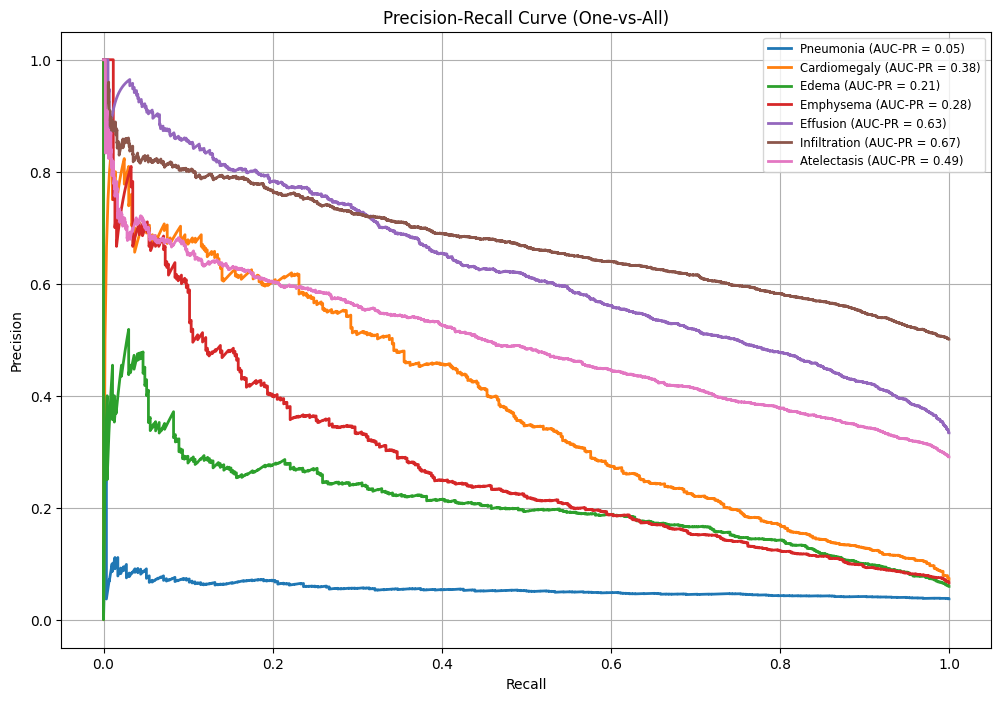

In [7]:
# True and predicted labels
y_true = val_gen.labels
y_pred = model.predict(val_gen)

# Compute Precision-Recall and AUC-PR for each class
precision = dict()
recall = dict()
auc_pr = dict()

for i in range(len(labels)):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    auc_pr[i] = auc(recall[i], precision[i])

# Plot
plt.figure(figsize=(12, 8))
for i in range(len(labels)):
    plt.plot(recall[i], precision[i], lw=2, label=f'{labels[i]} (AUC-PR = {auc_pr[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (One-vs-All)')
plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.show()

In [ ]:
model.save('thoracic_hybrid_resnet_vit.h5')  # Saves as HDF5 format
model.save('thoracic_hybrid_resnet_vit.keras')  # Saves as Keras format

## Testing the Model

1/1 [==============================] - 1s 518ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.546814..1.8962665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.877933..1.2861279].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4627304..1.8590702].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5982105..1.5694827].



Image 1 probabilities:
Pneumonia: 16.35%
Cardiomegaly: 7.99%
Edema: 8.13%
Emphysema: 10.51%
Effusion: 15.03%
Infiltration: 27.01%
Atelectasis: 12.92%

Image 2 probabilities:
Pneumonia: 14.90%
Cardiomegaly: 11.09%
Edema: 16.95%
Emphysema: 19.10%
Effusion: 14.81%
Infiltration: 16.47%
Atelectasis: 21.82%

Image 3 probabilities:
Pneumonia: 16.72%
Cardiomegaly: 6.75%
Edema: 8.40%
Emphysema: 27.51%
Effusion: 20.76%
Infiltration: 16.79%
Atelectasis: 18.51%

Image 4 probabilities:
Pneumonia: 18.75%
Cardiomegaly: 10.73%
Edema: 9.20%
Emphysema: 11.02%
Effusion: 14.19%
Infiltration: 23.88%
Atelectasis: 16.26%


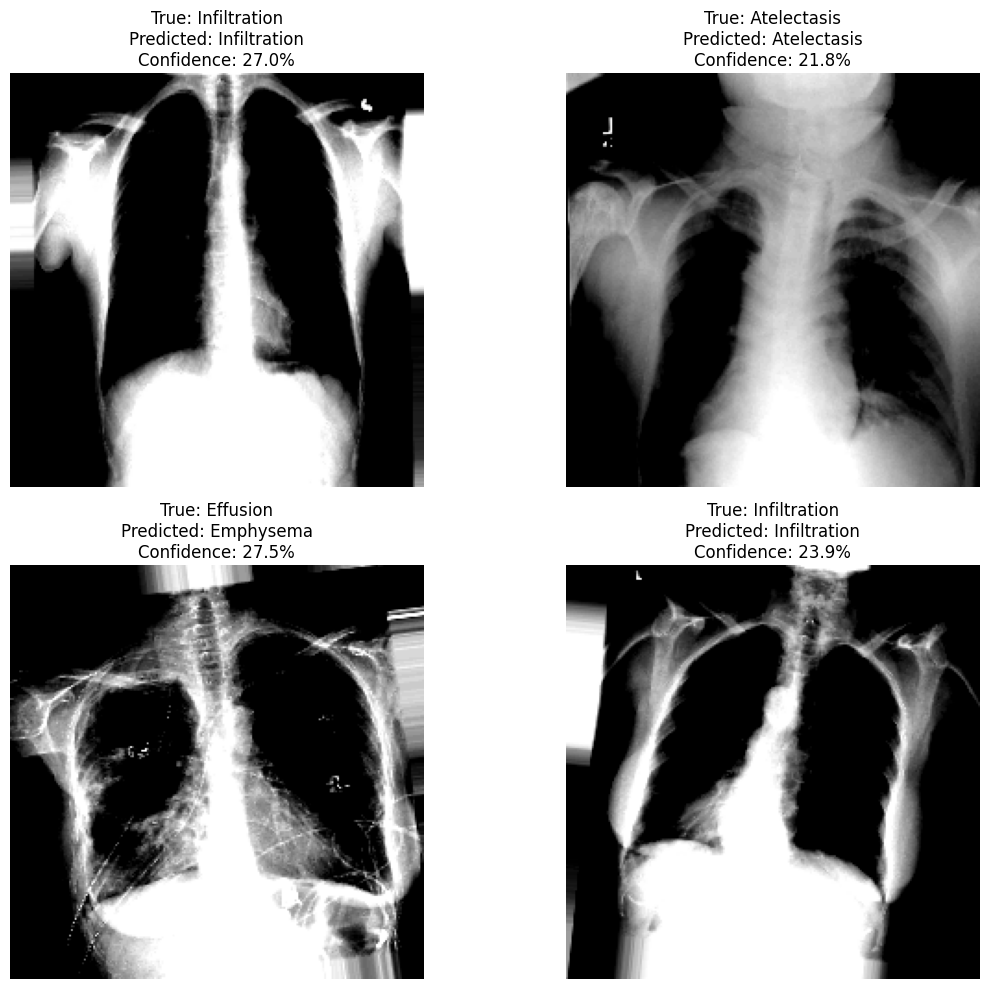

In [10]:
# Get a batch of images and labels from the validation generator
batch_images, batch_labels = next(train_gen)

# Make predictions on the batch
batch_preds = model.predict(batch_images)

# Define disease names mapping (based on your label assignments)
disease_names = ["Pneumonia", "Cardiomegaly", "Edema", 
                "Emphysema", "Effusion", "Infiltration", "Atelectasis"]

# Create a figure with 2x2 grid to display 4 random images
plt.figure(figsize=(12, 10))

# Display 4 random images from the batch
for i in range(4):
    # Choose a random image from the batch
    idx = np.random.randint(len(batch_images))
    img = batch_images[idx]
    
    # Get true and predicted labels
    true_label_idx = np.argmax(batch_labels[idx])
    pred_label_idx = np.argmax(batch_preds[idx])
    
    # Get disease names
    true_disease = disease_names[true_label_idx]
    pred_disease = disease_names[pred_label_idx]
    
    # Calculate confidence percentage
    confidence = batch_preds[idx][pred_label_idx] * 100
    
    # Plot the image in a subplot
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_disease}\nPredicted: {pred_disease}\nConfidence: {confidence:.1f}%")
    plt.axis('off')
    
    # Print detailed probabilities for this image
    print(f"\nImage {i+1} probabilities:")
    for j, disease in enumerate(disease_names):
        prob = batch_preds[idx][j] * 100
        print(f"{disease}: {prob:.2f}%")

plt.tight_layout()
plt.show()